In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import time
import importlib

from art.attacks import FastGradientMethod, ProjectedGradientDescent, CarliniL2Method
from art.classifiers import PyTorchClassifier

# Hyper Parameters
EPOCH = 10
BATCH_SIZE = 256
LR = .5  # learning rate
MNT = 0.9   # momentum variable
DOWNLOAD_Dataset = True
N_TEST_IMG = 5
m = 256     # Dictionary Size

# parameter settings:
# m     lambda    eta
# 100   .2        .1
# 200

torch.cuda.set_device(1)
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

In [2]:
data_dir = 'data/'

def get_data_loaders(data_dir,BSize):
    
    train_data = torchvision.datasets.MNIST(
        root= data_dir,
        train=True,                                     # this is training data
        transform=torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                  torchvision.transforms.Normalize((0.1307,), (0.3081,)),
                                 ]),    
        download=DOWNLOAD_Dataset,                        # download it if you don't have it
    )
    # Data Loader for easy mini-batch return in training, the image batch shape will be (50, 1, 28, 28)
    train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=BSize, shuffle=True)

    test_data = torchvision.datasets.MNIST(
        root= data_dir,
        train=False,                                     # this is testing data
        transform=torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                  torchvision.transforms.Normalize((0.1307,), (0.3081,)),
                                 ]),
        download=DOWNLOAD_Dataset,                        # download it if you don't have it
    )
    test_loader = torch.utils.data.DataLoader(dataset=test_data, batch_size=BSize, shuffle=True)
    
    return train_loader, test_loader


def preprocess(x):
    x = x.view(-1, 28*28).t()
    ms = torch.mean(x,dim=0)
    x = x - ms
    x = modelDL.NormDict(x).t()
    return x
    

In [3]:
import sparse_learnable_dictionary as modelDL

train_loader, test_loader = get_data_loaders(data_dir,BATCH_SIZE)


### First unsupervised training

In [4]:
import importlib
importlib.reload(modelDL)

# Training
Error = np.zeros((EPOCH,))
Nnz = np.zeros((EPOCH,))
Loss = np.zeros((EPOCH,))
N = len(train_loader.dataset)
DISPLAY_FREQ = 1 ;
TSHOW = np.round(DISPLAY_FREQ * N/BATCH_SIZE) # times per EPOCH to display information
t0 = time.perf_counter()
SC = 'fista' # 'fista' or 'IHT'
lambd = .04       # sparsity parameter: float numer if 'fista' or cardinality constraint if 'IHT'

model = modelDL.DictLearn(m,SC,lambd).to(device)
# optimizer = torch.optim.SGD(model.parameters(), lr=.001, momentum=.9)
optimizer = torch.optim.Adam(model.parameters())
loss_func = nn.MSELoss()

Err = []

In [5]:
# model.double()

for epoch in range(EPOCH):
    for step, (x, y) in enumerate(train_loader):
        b_x = preprocess(x).to(device).type(model.W.type())  # batch x, shape (batch, 28*28)
        b_y = preprocess(x).to(device).type(model.W.type())     # batch y, shape (batch, 28*28)
        b_label = (y).to(device)               # batch label

        decoded, encoded, errIHT = model(b_x)
        
        loss = loss_func(decoded, b_y)      # mean square error
#         loss = 1/len(b_label) * torch.norm(b_x-b_y)**2
        optimizer.zero_grad()               # clear gradients for this training step
        loss.backward()                     # backpropagation, compute gradients
        optimizer.step()                    # apply gradients
        model.zero_grad()
        model.normalize()
        
        
        if SC == 'IHT': Loss[epoch] = Loss[epoch] + loss.data
        elif SC == 'fista': Loss[epoch] = Loss[epoch] + loss.data + lambd * np.sum(np.abs(encoded.detach().cpu().numpy()))
        
        decoded = decoded.detach()
        err = np.linalg.norm( (decoded-b_x).cpu().numpy() ,'fro') / np.linalg.norm( b_x.cpu().numpy() ,'fro')
        Error[epoch] = Error[epoch] + errIHT[-1]
        Err = np.append(Err,errIHT[-1])
        Nnz[epoch] = Nnz[epoch] + np.count_nonzero(encoded.detach().cpu().numpy())/encoded.detach().cpu().numpy().size
#         print('Density: %.3f' % (np.count_nonzero(encoded.detach().cpu().numpy())/ BATCH_SIZE))
        
#         # for debugging:
#         print(Error[epoch]/(step+1))
#         if step%50==0:
#             plt.plot(errIHT); plt.show()
        
    Loss[epoch] /= len(train_loader.dataset)
    Error[epoch] /= (step+1)
    Nnz[epoch] /= (step+1)
    print('Epoch: ', epoch, ', Error: ', Error[epoch], ', | train loss: %.3e' % Loss[epoch], ' NNZ/sample: ', Nnz[epoch] )
    

model_unsup = model

Epoch:  0 , Error:  0.46936405174275664 , | train loss: 8.911e-02  NNZ/sample:  0.2425048828125
Epoch:  1 , Error:  0.35793605852634347 , | train loss: 7.768e-02  NNZ/sample:  0.16571044921875
Epoch:  2 , Error:  0.34325806878982706 , | train loss: 7.451e-02  NNZ/sample:  0.15169768637799202
Epoch:  3 , Error:  0.3354809731879133 , | train loss: 7.310e-02  NNZ/sample:  0.14410201268838654
Epoch:  4 , Error:  0.3309668580268292 , | train loss: 7.238e-02  NNZ/sample:  0.13933984201850622
Epoch:  5 , Error:  0.32791076822483795 , | train loss: 7.194e-02  NNZ/sample:  0.13615694519475843
Epoch:  6 , Error:  0.32621665673053013 , | train loss: 7.162e-02  NNZ/sample:  0.13422334278728945
Epoch:  7 , Error:  0.3253928354445924 , | train loss: 7.134e-02  NNZ/sample:  0.13282243444564495
Epoch:  8 , Error:  0.3250736209940403 , | train loss: 7.111e-02  NNZ/sample:  0.1318076492201352
Epoch:  9 , Error:  0.3250210363814171 , | train loss: 7.094e-02  NNZ/sample:  0.13131161953540557


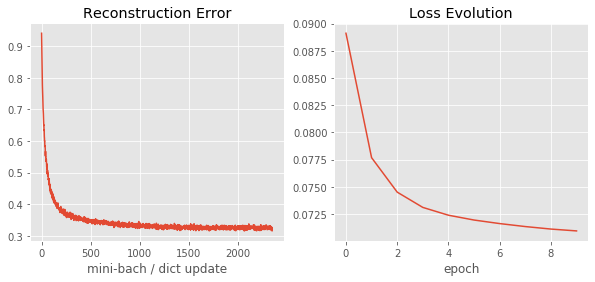

/home/jere/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:23: UserWarning: The default multichannel argument (None) is deprecated.  Please specify either True or False explicitly.  multichannel will default to False starting with release 0.16.
  warn('The default multichannel argument (None) is deprecated.  Please '


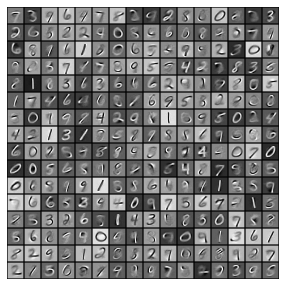

In [6]:
plt.style.use('ggplot')

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(Err); plt.title('Reconstruction Error'); plt.xlabel('mini-bach / dict update');
plt.subplot(1,2,2)
plt.plot(Loss); plt.title('Loss Evolution'); plt.xlabel('epoch')
plt.show(); 

from skimage import data, color
from skimage.transform import rescale, resize, downscale_local_mean
    
W = model_unsup.cpu().W.data.numpy().copy()
nat = int(np.floor(np.sqrt(m)))
M1 = modelDL.showFilters(W,nat,nat)
plt.figure(figsize=(5,5))
plt.imshow(rescale(M1,4,mode='constant'),cmap='gray')
plt.axis('off')
plt.show()

### Supervised Training

In [7]:
# Initialize
importlib.reload(modelDL)

BATCH_SIZE = 64
SC = 'fista' # 'fista' or 'IHT'
LMDS = torch.Tensor([.05, .05, .1, .1, .15, .15, .15, .2, .2, .2, .25, .25, .25, .3, .3, .3]).to(device)
EPOCH = 35

train_loader, test_loader = get_data_loaders(data_dir,BATCH_SIZE)

model = modelDL.DictLearn_supervised(m,SC).to(device)
optimizer = torch.optim.Adam(model.parameters(),lr=0.001,betas=(0.9, 0.9))
# optimizer = torch.optim.SGD(model.parameters(), lr=.02, momentum=.9)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=9, gamma=0.7)

# optimizer = torch.optim.SGD([
# 	{'params': model.W.parameters(), 'lr': 0.0}], lr=0.01, momentum=0.9, nesterov=True)


loss_func = nn.CrossEntropyLoss()

Using_Unsupervised_Dictionary_as_Init = True

if Using_Unsupervised_Dictionary_as_Init:
    model.init_dictionary(model_unsup.W)

Loss_sup = []
accuracy_train = []
accuracy_test = []
nnz = []

eta1 = 100
eta2 = .05

import time

In [8]:
I = torch.Tensor(np.eye(m)).type(model.W.type()).to(device)

# settings things up
model.learn_flag = True
model.float().to(device)

for epoch in range(EPOCH):
    
    model.lambd = nn.Parameter(LMDS[min(epoch,len(LMDS)-1)])
    
    for step, (x, y) in enumerate(train_loader):
        b_x = preprocess(x).to(device).type(model.W.type())
        b_label = (y).to(device)            # batch label

        out = model(b_x)
        
        Lclass = loss_func(out, b_label)
        Ldict = 1/m * torch.norm(I - torch.matmul(model.W.t() , model.W))**2
        Lw = 1/m * torch.norm(model.Wclass.weight)**2
        loss = Lclass + eta1*Ldict  + eta2*Lw 
        
        optimizer.zero_grad()               # clear gradients for this training step
        loss.backward()                     # backpropagation, compute gradients
        optimizer.step()                    # apply gradients
        model.zero_grad()
        model.normalize()
        
        Loss_sup = np.append(Loss_sup,loss.data)
        acc = torch.sum(torch.argmax(out, dim=1) == b_label).cpu().numpy() / len(b_label)
        accuracy_train = np.append(accuracy_train,acc)
        nnz = np.append(nnz,model.last_avg_nnz)
        
        if step % 10 == 0: # validate accuracy
            t = time.time()
            acc = 0
            for cnt, (x, y) in enumerate(test_loader):
                b_x = preprocess(x).to(device).type(model.W.type())
                b_label = (y).to(device)           # batch label

                out = model(b_x)

                acc += torch.sum(torch.argmax(out, dim=1) == b_label).cpu().numpy()
            
            elapsed = time.time() - t
            accuracy_test = np.append(accuracy_test,acc / len(test_loader.dataset))
            print('Epc/stp: %d/%d'%(epoch+1,step),'| Lmd = %.2f'%model.lambd,'| Loss: %.3f'%np.mean(Loss_sup[-20:-1]),
                  ' | nnz: %.2f' % nnz[-1],'| train acc.: %.2f' % accuracy_train[-1] , '| test acc: %.2f' % accuracy_test[-1],
                  ' | mu: %.4f'% modelDL.get_mu(model),' | Cw: %.4f'% modelDL.get_ClassifierConstant(model),'| T/I = %.2f'%elapsed)

        
    scheduler.step()
        
# Done training - change to exact Lasso solution
model.learn_flag = False


/home/jere/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jere/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Epc/stp: 1/0 | Lmd = 0.05 | Loss: nan  | nnz: 43.47 | train acc.: 0.27 | test acc: 0.19  | mu: 0.7798  | Cw: 0.8910 | T/I = 3.72
Epc/stp: 1/10 | Lmd = 0.05 | Loss: 585.825  | nnz: 43.61 | train acc.: 0.11 | test acc: 0.21  | mu: 0.7320  | Cw: 0.9016 | T/I = 3.71
Epc/stp: 1/20 | Lmd = 0.05 | Loss: 455.487  | nnz: 53.47 | train acc.: 0.19 | test acc: 0.25  | mu: 0.6906  | Cw: 0.9227 | T/I = 3.71
Epc/stp: 1/30 | Lmd = 0.05 | Loss: 315.871  | nnz: 52.98 | train acc.: 0.41 | test acc: 0.34  | mu: 0.6436  | Cw: 0.9523 | T/I = 3.72
Epc/stp: 1/40 | Lmd = 0.05 | Loss: 244.699  | nnz: 48.34 | train acc.: 0.52 | test acc: 0.44  | mu: 0.5923  | Cw: 1.0091 | T/I = 3.71
Epc/stp: 1/50 | Lmd = 0.05 | Loss: 191.946  | nnz: 48.94 | train acc.: 0.47 | test acc: 0.52  | mu: 0.5443  | Cw: 1.0815 | T/I = 3.72
Epc/stp: 1/60 | Lmd = 0.05 | Loss: 150.254  | nnz: 55.05 | train acc.: 0.64 | test acc: 0.58  | mu: 0.5318  | Cw: 1.1683 | T/I = 3.71
Epc/stp: 1/70 | Lmd = 0.05 | Loss: 112.919  | nnz: 60.48 | train ac

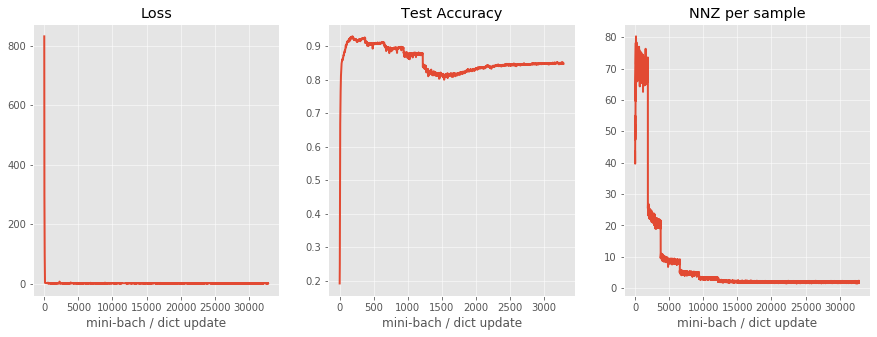

/home/jere/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:23: UserWarning: The default multichannel argument (None) is deprecated.  Please specify either True or False explicitly.  multichannel will default to False starting with release 0.16.
  warn('The default multichannel argument (None) is deprecated.  Please '


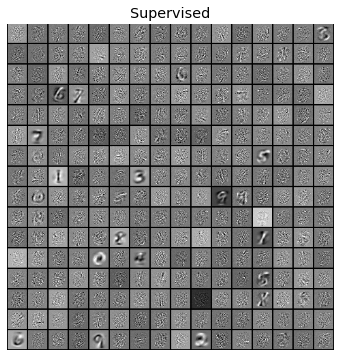

In [38]:
# torch.save(model.state_dict(), 'models/mnist_model_L03.tr')
# model.load_state_dict(torch.load('models/mnist_model.tr'))

from skimage import data, color
from skimage.transform import rescale, resize, downscale_local_mean
    
plt.style.use('ggplot')

plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.plot(Loss_sup); plt.title('Loss'); plt.xlabel('mini-bach / dict update');
plt.subplot(1,3,2)
plt.plot(accuracy_test); plt.title('Test Accuracy'); plt.xlabel('mini-bach / dict update');
plt.subplot(1,3,3)
plt.plot(nnz); plt.title('NNZ per sample'); plt.xlabel('mini-bach / dict update');
plt.show()

plt.figure(figsize=(6,6))
# plt.subplot(1,2,1)
# W1 = model.cpu().W.data.numpy().copy()
# M1 = modelDL.showFilters(W1,10,10)
# plt.imshow(rescale(M1,4,mode='constant'),cmap='gray')
# plt.title('Unsupervised')
# plt.subplot(1,2,2)
model_ = model
W2 = model_.W.data.cpu().numpy().copy()
M2 = modelDL.showFilters(W2,nat,nat)
plt.imshow(rescale(M2,4,mode='constant'),cmap='gray')
plt.title('Supervised')
plt.axis('off')
plt.show()

### Adversarial Attack and Analysis

In [10]:
# Step 5: Evaluate the ART classifier on benign test examples
_, test_loader = get_data_loaders(data_dir,200)
model.learn_flag = False


(x, y) = next(iter(test_loader))
b_x = preprocess(x).to(device).type(model.W.type())

min_pixel_value = torch.min(x)
max_pixel_value = torch.max(x)
criterion = nn.CrossEntropyLoss()
n = 28**2

classifier = PyTorchClassifier(
    model=model,
    clip_values=(min_pixel_value, max_pixel_value),
    loss=criterion,
    optimizer='',
    input_shape=(1,n),
    nb_classes=10,
)

predictions = classifier.predict(b_x)
Acc_0 = np.sum(np.argmax(predictions, axis=1) == (y.numpy())) / len(y)
print("Accuracy on benign test examples: {}%".format(Acc_0 * 100))

Accuracy on benign test examples: 86.0%


Analizing Margins

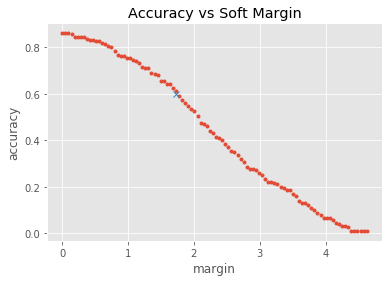

Target Accuracy 0.60 at Margin = 1.7287


In [11]:
importlib.reload(modelDL)

model.to(device)
(Accs,mrgns) = modelDL.getSoftMargin(model,b_x,y)
Cw = modelDL.get_ClassifierConstant(model)

Target_Accuracy = .6
target_margin = mrgns[np.where(Accs<Target_Accuracy)[0][0]-1]

plt.plot(mrgns,Accs,'.')
plt.plot(target_margin,Target_Accuracy,'x')
plt.xlabel('margin')
plt.ylabel('accuracy')
plt.title('Accuracy vs Soft Margin')
plt.show()

print('Target Accuracy %.2f at Margin = %.4f'%(Target_Accuracy,target_margin))


In [12]:
importlib.reload(modelDL)

mus = modelDL.get_babel(model)
Max_S = torch.sum(mus<1)

model.to(device)
print('Maximum sparsity: %d'%(Max_S))
tests = np.zeros(Max_S)
_,projs = modelDL.get_encoderGap(model,b_x,1)
for i in range(Max_S):
    s = i
    gap = projs[s]
    B1 = gap / 2
    B2 = target_margin / Cw * torch.sqrt(1-mus[s])
    tests[i] = min(B1.cpu(),B2.float())

Maximum sparsity: 60


Best s = 11
Bounds: B1 = 0.0761, B2 = 0.0737


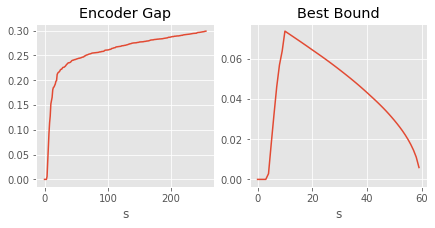

In [13]:
sbest = np.argmax(tests)
print('Best s = %d'%(sbest+1))
s = sbest
gap = projs[s]

plt.figure(figsize=(7,3))
plt.subplot(1,2,1)
plt.plot(projs.cpu().numpy())
plt.title('Encoder Gap')
plt.xlabel('s')

plt.subplot(1,2,2)
plt.plot(tests)
plt.title('Best Bound')
plt.xlabel('s')

B1 = gap / 2
B2 = target_margin / Cw * torch.sqrt(1-mus[s])
Bound = min(B1.cpu(),B2.float())
print('Bounds: B1 = %.4f, B2 = %.4f'%(B1,B2))

Analyzing Cerified Accuracy and comparing with Randomized Smoothing

In [20]:
importlib.reload(modelDL)
from art.wrappers.randomized_smoothing import *

model_d = model.double()
model.lambd = model.lambd.double()

classifier_rs = PyTorchClassifier(
    model=model_d,
    clip_values=(min_pixel_value, max_pixel_value),
    loss=criterion,
    optimizer='',
    input_shape=(1,n),
    nb_classes=10,
)

n_samples = 100
SIGMAS = np.linspace(0.001,.1,5)

Certified_Acc = []
Certified_Rad = []

distances = np.linspace(0,0.15,12)

for i in range(len(SIGMAS)):
    r_smoothed = RandomizedSmoothing(classifier,n_samples,scale = SIGMAS[i],alpha=.0001)
    (a,b) = r_smoothed.certify(b_x.double(), n_samples)
    Acc = np.zeros(len(distances))
    for j in range(len(distances)):
        Acc[j] = np.sum( (a == y.numpy()) & (b >= distances[j])) / len(y)
        
    Certified_Acc.append(Acc)
    Certified_Rad.append(distances)

Text(0.5, 0, 'Certified Radius')

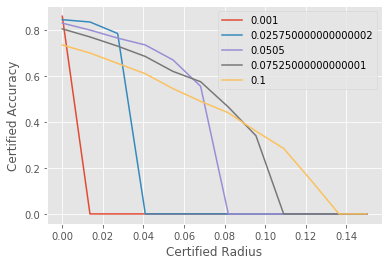

In [21]:
for i in range(len(Certified_Rad)):
    plt.plot(Certified_Rad[i],Certified_Acc[i],label=SIGMAS[i])
plt.legend()
plt.ylabel('Certified Accuracy')
plt.xlabel('Certified Radius')

Certified Accuracy with our bounds

In [22]:
model.float()
(Accs,mrgns) = modelDL.getSoftMargin(model,b_x,y)
# plt.plot(mrgns,Accs)

mus = modelDL.get_babel(model)
Max_S = torch.sum(mus<1)
print('Maximum sparsity: %d'%(Max_S))

Certified_Acc_sparse = []
Certified_Rad_sparse = []
Certified_s_sparse = []

# testing encoder Gaps at different sparsity levels
gap,projs = modelDL.get_encoderGap(model,b_x,s)

B1 = projs / 2  # encoder gap as a function of sparsity


for i in range(len(mrgns)):
    target_margin = mrgns[i]
    tests = np.zeros(Max_S)
    for j in range(1,Max_S):
        B2 = target_margin / Cw * torch.sqrt(1-mus[s-1])
        tests[j] = min(B1[j].cpu(),B2.float())
    
    Certified_s_sparse.append(np.argmax(tests))
    Certified_Rad_sparse.append(np.max(tests))
    Certified_Acc_sparse.append(Accs[i])


Maximum sparsity: 60


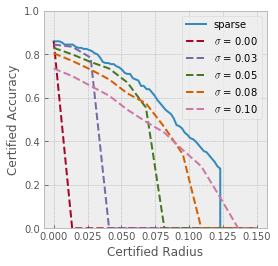

In [37]:
plt.style.use('bmh')

plt.figure(figsize=(4,4))
plt.plot(Certified_Rad_sparse,Certified_Acc_sparse,label = 'sparse')
for i in range(len(Certified_Rad)):
    plt.plot(Certified_Rad[i],Certified_Acc[i],'--',label=r'$\sigma$ = %.2f'%np.round(SIGMAS[i],2))
plt.legend(loc='upper right')
plt.ylabel('Certified Accuracy')
plt.ylim([0,1])
plt.xlabel('Certified Radius')
# plt.grid()
plt.savefig('CertAcc_L03_trans.pdf',transparent = True,dpi = 100)